In [9]:
import pboxplots
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import pickle 

import time

## Simulations settings

In [10]:
M = 1000
eps_vector = ['oracle', 0.5, 1, 5, 10]
n_vector = [500, 5000, 50000]
t_vector = [5, 10]
method_vector = ['PrivateQuantile', 'unbounded', 'JointExp', 'ApproxQuantile', 'DPBoxplot']

In [11]:
def do_simulation():
    #airbnb
    df = pd.read_csv('data/AB_NYC_2019.csv')
    price = []
    for i in df.price:
        if pd.isnull(i):
            price.append(None)
        else:
            price.append(int(i))
    df['price'] = price
    df = df.dropna(subset = 'price')
    x = np.array(list(df.price))
    x_airbnb = (x-np.mean(x))/np.std(x)
    
    #skew to have mean 0, variance 1
    a = 20  # skewness parameter (positive for right-skewed, negative for left-skewed)
    loc = -1.319
    scale = 1.655 
    
    #t
    degrees_freedom = 10
    
    #uniform
    low = -np.sqrt(3)
    high = np.sqrt(3)
    
    #beta
    alpha = 2.0  # shape parameter (alpha > 0)
    beta = 2.0  # shape parameter (beta > 0)
    
    bp_distributions = {}
    x = np.random.standard_normal(size=1000000)
    bp_distributions['normal'] = pboxplots.get_box_plot(x, dp = False, eps = 1)
    x = scipy.stats.skewnorm.rvs(a, loc, scale, size=1000000)
    bp_distributions['skew'] = pboxplots.get_box_plot(x, dp = False, eps = 1)
    x = np.random.uniform(low, high, size=1000000)
    bp_distributions['uniform'] = pboxplots.get_box_plot(x, dp = False, eps = 1)
    x = scipy.stats.t.rvs(degrees_freedom, size=1000000)
    x = (x-np.mean(x))/np.std(x)
    bp_distributions['t'] = pboxplots.get_box_plot(x, dp = False, eps = 1)
    bp_distributions['airbnb'] = pboxplots.get_box_plot(x_airbnb, dp = False, eps = 1)
    x = np.random.beta(alpha, beta, size = 1000000)
    x = (x-np.mean(x))/np.std(x)
    bp_distributions['beta'] = pboxplots.get_box_plot(x, dp = False, eps = 1)
    
    distributions = ['normal', 'skew', 'uniform', 'airbnb', 'beta','normal', 'skew', 'uniform', 'airbnb', 'beta']
    
    for sim_type in ['mix']: 
        all_results = []
        
        print('*'*20)
        print(sim_type)
        print('*'*20)
        
        for t in t_vector:
    
            for eps in eps_vector:
                if eps!='oracle':
                    temp_method_vector = method_vector
                else:
                    temp_method_vector = ['oracle']
                    bp_oracle = {'equal':{}}
                    
                for N in n_vector:
    
                    all_distances_private = {}
                    all_distances_nonprivate = {}
                    all_distances_population = {}
                    
                    for method in method_vector:
                        all_distances_private[method] = {'equal':[]}
                        all_distances_nonprivate[method] = {'equal':[]}
                        all_distances_population[method] = {'equal':[]}
                    all_distances_private['oracle'] = {'equal':[]}
                    all_distances_nonprivate['oracle'] = {'equal':[]}
                    all_distances_population['oracle'] = {'equal':[]}
    
                    print([t,eps,N])
    
                    for i in range(M):
                        if int(i/100) == i/100:
                            print(i)
                            
                        np.random.seed(i)
    
                        #sample different n
                        vector = np.arange(1, N+1)
                        flag = True
                        while flag == True:
                            sampled_numbers = np.random.choice(vector, t-1, replace=False)
                            sampled_numbers = [0] + list(np.sort(sampled_numbers)) + [N]
                            sampled_N = [sampled_numbers[ii+1]-sampled_numbers[ii] for ii in range(len(sampled_numbers)-1)]
                            flag = np.sum(np.array(sampled_N)>25)!=t
                        total_log_sum = np.sum(np.log(sampled_N))
                        
                        mean = np.random.uniform(-1, 1, t)
                        std = np.random.uniform(0.5, 1.5, t)
                        
                        samples = {}
                            
                        for ti in range(t):
    
                            n = sampled_N[ti]
                            
                            if sim_type == 'normal':
                                x = np.random.standard_normal(size=n)
                                
                            else:
                                option = distributions[ti]
                                if option == 'normal':
                                    x = np.random.standard_normal(size=n)
                                elif option == 'skew': 
                                    x = scipy.stats.skewnorm.rvs(a, loc, scale, size=n)
                                elif option == 't':
                                    x = scipy.stats.t.rvs(degrees_freedom, size=n)
                                elif option == 'uniform':
                                    x = np.random.uniform(low, high, size=n)
                                elif option == 'airbnb':
                                    x = np.random.choice(x_airbnb, size=n, replace=False)
                                elif option == 'beta':
                                    x = np.random.beta(alpha, beta, size = n)
                                    x = (x-np.mean(x))/np.std(x)
    
                            x = x*std[ti] + mean[ti]
    
                            samples[ti] = np.array(x)
                            
                        all_bp_private = {}
                        all_bp_nonprivate = {}
                            
                        for method in temp_method_vector:
                            all_bp_private[method] = {'equal':[]}
                            all_bp_nonprivate[method] = {'equal':[]}
    
    
                        #calculate box plots
                        for ti in range(t):
                            x = samples[ti]
    
                            if eps!='oracle':
                                        
                                for method in method_vector:
                                    
                                    for budget in ['equal']:
                                        if budget == 'equal':
                                            kbudget = 1
                                            
                                        bp_private = pboxplots.get_box_plot(x, dp = True, eps = eps*kbudget, method = method)
                                        bp_nonprivate = pboxplots.get_box_plot(x, dp = False, eps = eps*kbudget, method = method)
                                        all_bp_private[method][budget].append(bp_private)
                                        all_bp_nonprivate[method][budget].append(bp_nonprivate)
    
                            else:
                                bp_private = pboxplots.get_box_plot(x, dp = False, eps = 1) #calculate non-private since it is oracle
                                
                                if sim_type == 'normal':
                                    box_whiskers = list(np.array(bp_distributions['normal'][0])*std[ti] + mean[ti])
                                    outliers = bp_distributions['normal'][1]
                                
                                elif sim_type == 'mix':
                                    box_whiskers = list(np.array(bp_distributions[distributions[ti]][0])*std[ti] + mean[ti])
                                    outliers = bp_distributions[distributions[ti]][1]
                                
                                bp_nonprivate = (box_whiskers, outliers)
                                
                                for budget in ['equal']:
                                    all_bp_private['oracle'][budget].append(bp_private)
                                    all_bp_nonprivate['oracle'][budget].append(bp_nonprivate)
                                    bp_oracle[budget][ti] = bp_nonprivate   
                            
                        for method in temp_method_vector:
                            
                            for budget in ['equal']:
                                
                                distances_private = np.zeros((7, t, t))
                                distances_nonprivate = np.zeros((7, t, t))
                                distances_population = np.zeros((7, t, t))
        
                                #calculate pairwise distances
                                for ti in range(t):
        
                                    for tj in range(t):
        
                                        if ti==tj:
                                            for k in range(7):
                                                distances_private[k,ti,tj] = 0
                                                distances_nonprivate[k,ti,tj] = 0
                                        else:
                                            bp_private_i = all_bp_private[method][budget][ti]
                                            bp_private_j = all_bp_private[method][budget][tj]
        
                                            bp_nonprivate_i = all_bp_nonprivate[method][budget][ti]
                                            bp_nonprivate_j = all_bp_nonprivate[method][budget][tj]
    
                                            bp_population_i = bp_oracle[budget][ti]
                                            bp_population_j = bp_oracle[budget][tj]
        
                                            d_private = pboxplots.box_plot_distance(bp_private_i,bp_private_j)
                                            d_nonprivate = pboxplots.box_plot_distance(bp_nonprivate_i,bp_nonprivate_j)
                                            d_population = pboxplots.box_plot_distance(bp_population_i,bp_population_j)
        
                                            for k in range(7):
                                                distances_private[k,ti,tj] = d_private[k]
                                                distances_nonprivate[k,ti,tj] = d_nonprivate[k]
                                                distances_population[k,ti,tj] = d_population[k]
    
                                all_distances_private[method][budget].append(distances_private)    
                                all_distances_nonprivate[method][budget].append(distances_nonprivate)
                                all_distances_population[method][budget].append(distances_population)
    
                    for method in temp_method_vector:
                        for budget in ['equal']:
                            all_results.append([t, eps, N, method, budget, all_distances_private[method][budget], all_distances_nonprivate[method][budget], all_distances_population[method][budget]]) 
    
    return all_results

In [14]:
def process_simulated_data(data):
    
    def custom_sort(item):
            if isinstance(item, float):
                return (0, item)
            elif isinstance(item, int):
                return (0, item)
            else:
                return (1, item)
    
    results = {}

    sim_type = 'mix'      

    n_vector = []
    t_vector = []
    eps_vector = []
    method_vector = []
    budget_vector = []

    for z in data:
        t = z[0]
        eps = z[1]
        n = z[2]
        method = z[3]
        budget = z[4]
        
        eps_vector.append(eps)
        n_vector.append(n)
        t_vector.append(t)
        method_vector.append(method)
        budget_vector.append(budget)

    eps_vector = list(set(eps_vector))
    n_vector = list(set(n_vector))
    t_vector = list(set(t_vector))
    method_vector = list(set(method_vector))

    eps_vector = sorted(eps_vector, key=custom_sort)
    n_vector = sorted(n_vector, key=custom_sort)
    t_vector = sorted(t_vector, key=custom_sort)
    method_vector = sorted(method_vector, key=custom_sort)
    budget_vector = sorted(budget_vector, key=custom_sort)

    #n_vector = n_vector[:3]

    results_dict = {}

    for t in t_vector:
        results_dict[t] = {}
        for eps in eps_vector:
            results_dict[t][eps] = {}
            for n in n_vector:
                results_dict[t][eps][n] = {}
                for method in method_vector:
                    results_dict[t][eps][n][method] = {}

    for z in data:
        t = z[0]
        eps = z[1]
        n = z[2]
        method = z[3]
        budget = z[4]
        
        #relative distance
        result = np.mean(np.abs(1-(np.array(z[5])+1)/(np.array(z[7])+1)), axis = 0)

        list_of_results = [result[i, :, :] for i in range(result.shape[0])]
        results_dict[t][eps][n][method][budget] = list_of_results
    results[sim_type] = results_dict

    row_list = []
        
    for i_eps in range(len(eps_vector)):
        eps = eps_vector[i_eps]
        for i_n in range(len(n_vector)):
            n = n_vector[i_n]

            for i_t in range(len(t_vector)):
                t = t_vector[i_t]

                if eps!='oracle':
                    
                    for method in method_vector:
                        if method == 'oracle':
                            continue

                        for budget in budget_vector:
                            darray0 = [results[sim_type][t][eps][n][method][budget][0][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray1 = [results[sim_type][t][eps][n][method][budget][1][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray2 = [results[sim_type][t][eps][n][method][budget][2][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray3 = [results[sim_type][t][eps][n][method][budget][3][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray4 = [results[sim_type][t][eps][n][method][budget][4][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray5 = [results[sim_type][t][eps][n][method][budget][5][i][j] for i in range(t) for j in range(t) if (i < j)]
                            darray6 = [results[sim_type][t][eps][n][method][budget][6][i][j] for i in range(t) for j in range(t) if (i < j)]
                            for ii in range(len(darray0)):
                                row_list.append([sim_type, eps, n, t, method, budget, darray0[ii], darray1[ii], darray2[ii], darray3[ii], darray4[ii], darray5[ii], darray6[ii]])
                    
                else:
                    darray0 = [results[sim_type][t][eps][n]["oracle"][budget][0][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray1 = [results[sim_type][t][eps][n]["oracle"][budget][1][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray2 = [results[sim_type][t][eps][n]["oracle"][budget][2][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray3 = [results[sim_type][t][eps][n]["oracle"][budget][3][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray4 = [results[sim_type][t][eps][n]["oracle"][budget][4][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray5 = [results[sim_type][t][eps][n]["oracle"][budget][5][i][j] for i in range(t) for j in range(t) if (i < j)]
                    darray6 = [results[sim_type][t][eps][n]["oracle"][budget][6][i][j] for i in range(t) for j in range(t) if (i < j)]

                    for ii in range(len(darray0)):
                        row_list.append([sim_type, eps, n, t, 'oracle', 'oracle', darray0[ii], darray1[ii], darray2[ii], darray3[ii], darray4[ii], darray5[ii], darray6[ii]])
                    
    df = pd.DataFrame(row_list)
    df.columns = ['sim', 'eps','n', 't', 'method', 'budget', 'overall', 'd2', 'scale', 'location', 'skewness', 'outliers', 'd3']

    # File path to save the pickle file
    file_path = 'simulation_results/multiple_M' + str(M) + '.pkl'

    # Open the file in binary write mode
    with open(file_path, 'wb') as file:
        # Dump the data into the file using pickle
        pickle.dump(df, file)
            
    return df

# Simulations

In [15]:
start_time = time.time()

# Run full simulation
all_results = do_simulation()

# Process and save simulated results
df = process_simulated_data(all_results)

print(time.time()-start_time)

********************
mix
********************
[5, 'oracle', 500]
0
100
200
300
400
500
600
700
800
900
[5, 'oracle', 5000]
0
100
200
300
400
500
600
700
800
900
[5, 'oracle', 50000]
0
100
200
300
400
500
600
700
800
900
[5, 0.5, 500]
0


C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:117: RuntimeWarning: divide by zero encountered in log
  log_alpha = np.log(np.zeros([num_quantiles, num_intervals, num_quantiles]))
C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:96: RuntimeWarning: divide by zero encountered in log
  np.log(y, out=y)
C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:116: RuntimeWarning: divide by zero encountered in log
  data_intervals_log_sizes = np.log(data_intervals[:, 1] - data_intervals[:, 0])


100
200


C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\approximate_quantiles_algo.py:81: RuntimeWarning: divide by zero encountered in log
  idx_left = racing_sample(np.log(intervals) + (epsilon / (2.0 * sensitivity) * utility))


300
400
500
600
700
800
900
[5, 0.5, 5000]
0
100
200
300
400
500
600
700
800
900
[5, 0.5, 50000]
0
100
200
300
400
500
600
700
800
900
[5, 1, 500]
0
100
200
300
400
500
600
700
800
900
[5, 1, 5000]
0
100
200
300
400
500
600
700
800
900
[5, 1, 50000]
0
100
200
300
400
500
600
700
800
900
[5, 5, 500]
0
100
200
300
400
500
600
700
800
900
[5, 5, 5000]
0
100
200
300
400
500
600
700
800
900
[5, 5, 50000]
0
100
200
300
400
500
600
700
800
900
[5, 10, 500]
0
100
200
300
400
500
600
700
800
900
[5, 10, 5000]
0
100
200
300
400
500
600
700
800
900
[5, 10, 50000]
0
100
200
300
400
500
600
700
800
900
[10, 'oracle', 500]
0
100
200
300
400
500
600
700
800
900
[10, 'oracle', 5000]
0
100
200
300
400
500
600
700
800
900
[10, 'oracle', 50000]
0
100
200
300
400
500
600
700
800
900
[10, 0.5, 500]
0
100
200
300
400
500
600
700
800
900
[10, 0.5, 5000]
0
100
200
300
400
500
600
700
800
900
[10, 0.5, 50000]
0
100
200
300
400
500
600
700
800
900
[10, 1, 500]
0
100
200
300
400
500
600
700
800
900
[10, 1, 5000]

TypeError: process_simulated_data() missing 1 required positional argument: 'data'

In [17]:
# read saved simulations

file_path = 'simulation_results/multiple_M' + str(M) + '.pkl'

with open(file_path, 'rb') as f:
    # Load the data from the pickle file
    df = pickle.load(f)

## Plots

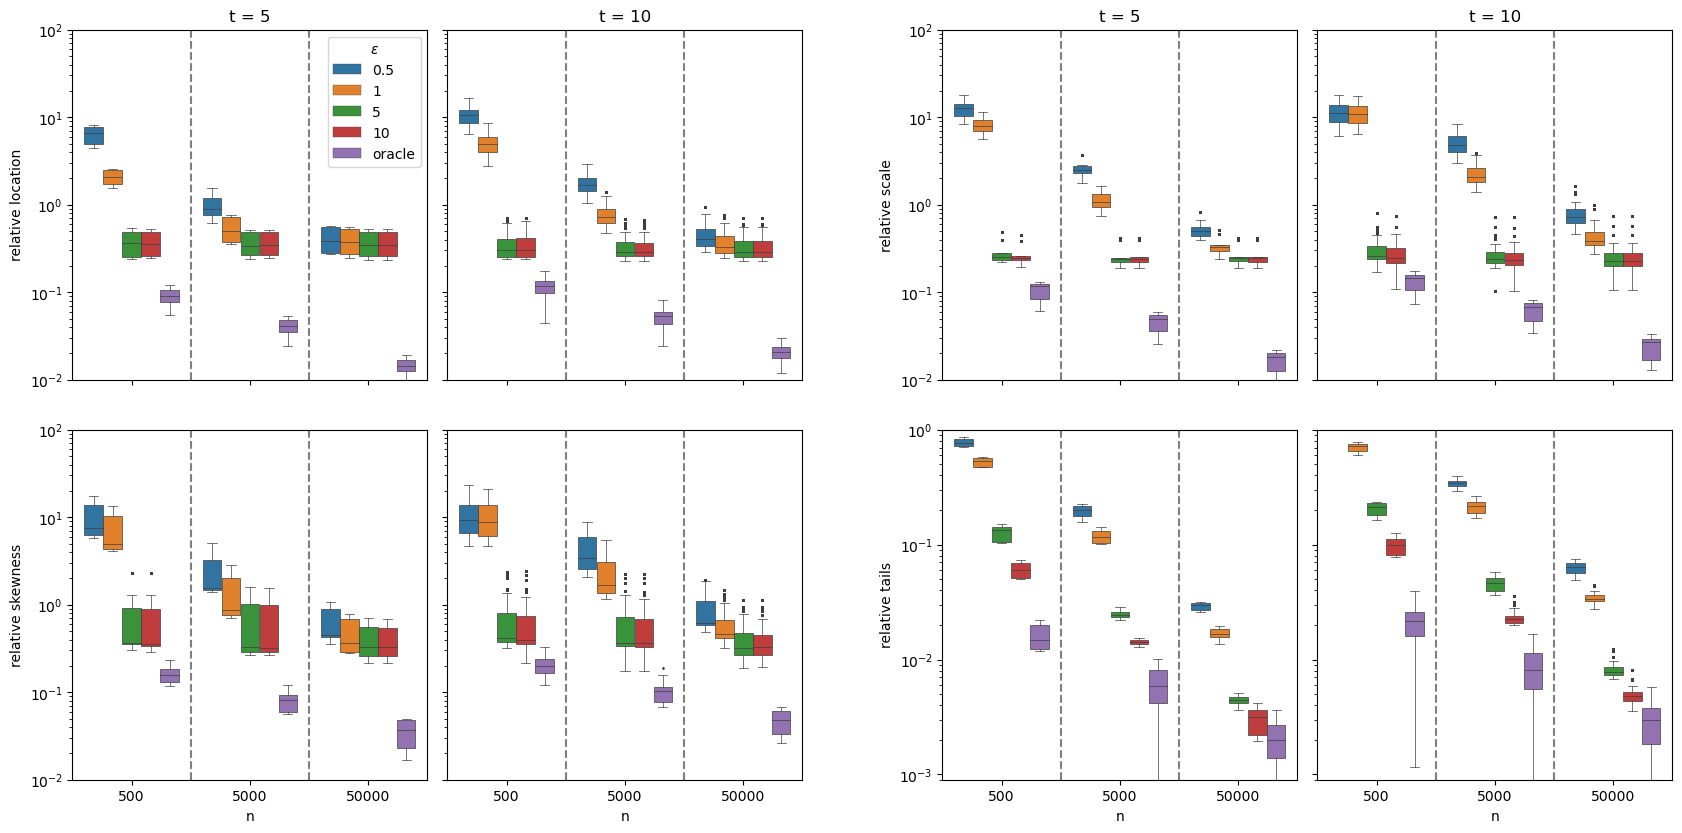

In [20]:
# Create a subplot grid with shared y-axes for each row
distances = ['overall', 'location', 'scale', 'skewness', 'outliers']
eps_vector = [0.5, 1, 5, 10, 'oracle']
t_vector = [4, 8]
sims = ['mix']
method = 'DPBoxplot'
budget = 'equal'
n_vector = [500, 5000, 50000]


fig, axs = plt.subplots(2,4, figsize=(20,10), sharex='col')  
sim_type = sims[0]
    
ax = axs[0,0]
curdf = df[(df['sim'] == sim_type)&(df['eps'].isin(eps_vector))&(df['n'].isin(n_vector))&((df['method']==method)|(df['method']=='oracle'))&((df['budget']==budget)|(df['budget']=='oracle'))].copy()

sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='location',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylabel('relative location')
ax.set_title('t = 5')
ax.set_ylim([0.01,100])
ax.set_xlabel('')
ax.legend(title=r'$\epsilon$', loc='upper right')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]

ax = axs[0,1]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='location',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylabel('relative location')
ax.set_ylabel('')
ax.set_ylim([0.01,100])
ax.set_title('t = 10')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[0,2]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='scale',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_title('t = 5')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative scale')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[0,3]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='scale',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_title('t = 10')
ax.set_ylabel('')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[1,0]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='skewness',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative skewness')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[1,1]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='skewness',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative skewness')
ax.set_ylabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[1,2]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='outliers',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.0009,1])
ax.set_ylabel('relative tails')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[1,3]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='outliers',hue='eps', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.0009,1])
ax.set_ylabel('relative tails')
ax.set_ylabel('')
ax.set_yticklabels([])
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

#line = Line2D([line_x_position, line_x_position], [0.05, 0.95], transform=fig.transFigure, color="black", linewidth=2)
#fig.add_artist(line)

positions = [
    [0.05, 0.50, 0.1775, 0.35],  # First row, first column
    [0.2375, 0.50, 0.1775, 0.35], # First row, second column
    [0.485, 0.50, 0.1775, 0.35],  # First row, third column
    [0.6725, 0.50, 0.1775, 0.35], # First row, fourth column
    [0.05, 0.1, 0.1775, 0.35],    # Second row, first column
    [0.2375, 0.1, 0.1775, 0.35],  # Second row, second column
    [0.485, 0.1, 0.1775, 0.35],   # Second row, third column
    [0.6725, 0.1, 0.1775, 0.35]   # Second row, fourth column
]

for ax, pos in zip(axs.flat, positions):
    ax.set_position(pos)

#plt.tight_layout()

plt.savefig('generated_figures/multiple_plot_eps.pdf')

plt.show()

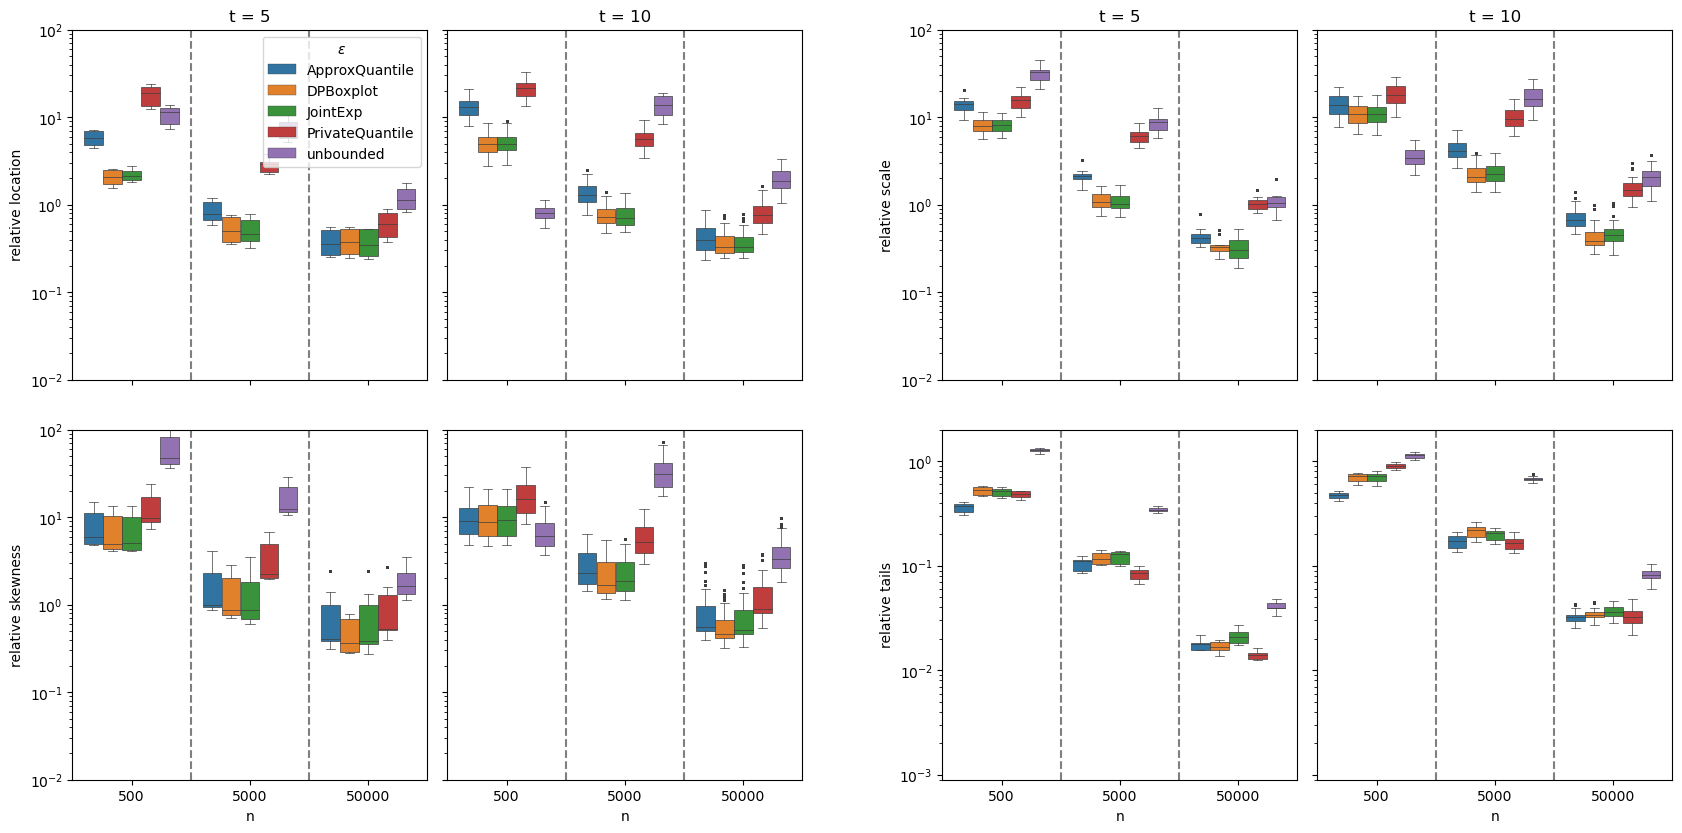

In [19]:
# Create a subplot grid with shared y-axes for each row
distances = ['overall', 'location', 'scale', 'skewness', 'outliers']
t_vector = [4, 8]
sims = ['mix']
method = 'DPBoxplot'
budget = 'equal'
n_vector = [500, 5000, 50000]


fig, axs = plt.subplots(2,4, figsize=(20,10), sharex='col')  
sim_type = sims[0]
    
ax = axs[0,0]
curdf = df[(df['sim'] == sim_type)&(df['method'].isin(method_vector))&(df['n'].isin(n_vector))&((df['eps']==1)|(df['eps']=='oracle'))&((df['budget']==budget)|(df['budget']=='oracle'))].copy()

sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='location',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylabel('relative location')
ax.set_title('t = 5')
ax.set_ylim([0.01,100])
ax.set_xlabel('')
ax.legend(title=r'$\epsilon$', loc='upper right')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]

ax = axs[0,1]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='location',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylabel('relative location')
ax.set_ylabel('')
ax.set_ylim([0.01,100])
ax.set_title('t = 10')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[0,2]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='scale',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_title('t = 5')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative scale')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[0,3]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='scale',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_title('t = 10')
ax.set_ylabel('')
ax.set_xlabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[1,0]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='skewness',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative skewness')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[1,1]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='skewness',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.01,100])
ax.set_ylabel('relative skewness')
ax.set_ylabel('')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)
ax.set_yticklabels([])

ax = axs[1,2]
sns.boxplot(curdf[curdf['t'] == 5], x= 'n',y='outliers',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.0009,2])
ax.set_ylabel('relative tails')
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

ax = axs[1,3]
sns.boxplot(curdf[curdf['t'] == 10], x= 'n',y='outliers',hue='method', ax=ax, palette = 'tab10', linewidth=0.5, fliersize = 1)
ax.set_yscale('log')
ax.set_ylim([0.0009,2])
ax.set_ylabel('relative tails')
ax.set_ylabel('')
ax.set_yticklabels([])
[ax.axvline(x+.5,color='k', linestyle = '--', alpha = 0.5) for x in ax.get_xticks()[:-1]]
ax.legend().set_visible(False)

#line = Line2D([line_x_position, line_x_position], [0.05, 0.95], transform=fig.transFigure, color="black", linewidth=2)
#fig.add_artist(line)

positions = [
    [0.05, 0.50, 0.1775, 0.35],  # First row, first column
    [0.2375, 0.50, 0.1775, 0.35], # First row, second column
    [0.485, 0.50, 0.1775, 0.35],  # First row, third column
    [0.6725, 0.50, 0.1775, 0.35], # First row, fourth column
    [0.05, 0.1, 0.1775, 0.35],    # Second row, first column
    [0.2375, 0.1, 0.1775, 0.35],  # Second row, second column
    [0.485, 0.1, 0.1775, 0.35],   # Second row, third column
    [0.6725, 0.1, 0.1775, 0.35]   # Second row, fourth column
]

for ax, pos in zip(axs.flat, positions):
    ax.set_position(pos)

#plt.tight_layout()

plt.savefig('generated_figures/multiple_plot_methods.pdf')

plt.show()